## 1. Preparation
### 1.1 Libraries


In [51]:
import copy
import os
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

### 1.2 Import Data

In [52]:
data = pd.read_csv('data/data.csv')
sensors = data['sensor'].unique()

## 2. Empirical Graph

In [53]:
def add_edges(G, z, numneighbors=4):
    """
    Adds normalized similarity-based weighted edges to a graph using k-nearest neighbors.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node has a vector attribute used for computing distances.
    numneighbors : int
        Number of nearest neighbors.
    z : str
        Node attribute to use as representation vector.

    Returns
    -------
    networkx.Graph
        Graph with added normalized weighted edges.
    """
    graph = copy.deepcopy(G)
    
    node_list = list(graph.nodes)
    
    representation_vector = np.array([graph.nodes[node][z] for node in node_list])
    representation_vector = representation_vector.reshape(len(node_list), -1)

    adjacency_matrix = kneighbors_graph(
        representation_vector,
        numneighbors,
        mode='distance',
        metric='minkowski',
        p=2,
        include_self=False
    )

    # Compute similarities (1 / distance)
    coo = adjacency_matrix.tocoo()
    similarities = np.array([1 / (dist) for dist in coo.data]) * 1000

    # Create weighted edges
    edges = [
        (node_list[i], node_list[j], {'weight': weight})
        for (i, j, weight) in zip(coo.row, coo.col, similarities)
    ]

    graph.add_edges_from(edges)
    return graph

def train_val_split_by_blocks(X, y, block_size=50, val_per_block=10, seed=42):
    """
    Splits X and y into training and validation sets by selecting val_per_block samples
    from each consecutive block of block_size rows.

    Parameters:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Label vector.
        block_size (int): Size of each block.
        val_per_block (int): Number of validation samples per block.
        seed (int): Random seed for reproducibility.

    Returns:
        X_train, y_train, X_val, y_val
    """
    np.random.seed(seed)
    num_blocks = X.shape[0] // block_size
    val_idx = []

    for i in range(num_blocks):
        block_indices = np.arange(i * block_size, (i + 1) * block_size)
        val_samples = np.random.choice(block_indices, val_per_block, replace=False)
        val_idx.extend(val_samples)

    val_idx = np.array(val_idx)
    mask = np.ones(X.shape[0], dtype=bool)
    mask[val_idx] = False

    return X[mask], y[mask], X[val_idx], y[val_idx]

def plot_sensor_graph(G, filename=None, seed=2):
    
    # Create layout
    pos = nx.spring_layout(G, seed=seed)  # positions for all nodes

    plt.figure(figsize=(8, 6))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=4)

    # Optional: draw edge weights if available
    edge_weights = nx.get_edge_attributes(G, 'weight')
    if edge_weights:
        edge_labels = {k: f"{v:.2f}" for k, v in edge_weights.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

    # Final layout adjustments
    plt.title("Sensor Similarity Graph")
    plt.axis('off')
    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
def create_graph(sensors):
    # Create a networkX graph
    G = nx.Graph()

    # Add one node per sensor
    G.add_nodes_from(sensors)
    
    for sensor in sensors:
        # Extract data of the given sensor
        sensor_data = data[data.sensor == sensor]

        # Feature matrix and label vector
        X = np.column_stack([
            sensor_data['decay'].to_numpy(), # coefficient of the line fitted to the 
            sensor_data['ymax'].to_numpy(),
            sensor_data['tmax'].to_numpy(),
            sensor_data['int0'].to_numpy(),
            sensor_data['intp'].to_numpy(),
            sensor_data['temp'].to_numpy()
        ])
        y = sensor_data['conc_err'].to_numpy()

        X_train, y_train, X_val, y_val = train_val_split_by_blocks(X, y, block_size=50, val_per_block=10, seed=42)

        # Assign attributes
        k = sensor_data['k'].iloc[0]
        b = sensor_data['b'].iloc[0]
        G.nodes[sensor].update({
            'sensor': sensor, 
            'X': X,
            'y': y,
            'X_train': X_train,
            'y_train': y_train.reshape(-1, 1),
            'X_val': X_val,
            'y_val': y_val.reshape(-1, 1),
            'z': np.array([np.mean(X[:, 0]), k, b])
        })
    
    return G

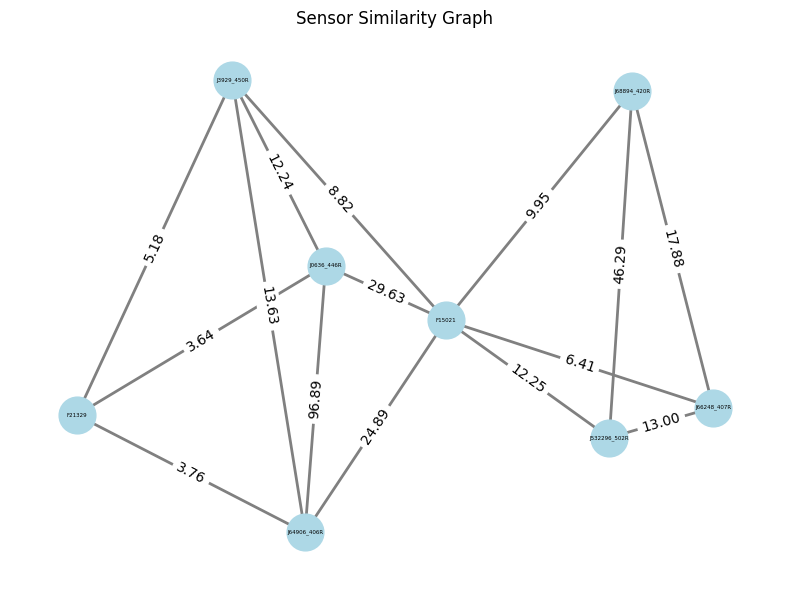

In [54]:
# Create and connect the graph
G_sensors = create_graph(sensors)
G_sensors = add_edges(G_sensors, 'z', 3)

plot_sensor_graph(G_sensors, filename=None, seed=3)

## 3. Modelling
### 3.1 Define Local Models

In [55]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        # Register feature-wise standardization buffers
        self.register_buffer('feature_mean', torch.zeros(input_dim))
        self.register_buffer('feature_std', torch.ones(input_dim))

        # Main MLP architecture
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LayerNorm(64),
            nn.GELU(),

            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.Tanh(),

            nn.Linear(32, 1)
        )

        # Residual projection layer to capture identity mapping
        self.residual = nn.Linear(input_dim, 1)

    def set_scaler(self, mean, std):
        """Set standardization parameters after fitting on training data."""
        self.feature_mean.copy_(torch.tensor(mean, dtype=torch.float32))
        self.feature_std.copy_(torch.tensor(std, dtype=torch.float32))

    def forward(self, x):
        # Normalize input
        x_norm = (x - self.feature_mean) / self.feature_std.clamp(min=1e-6)

        # Compute both paths
        out_main = self.net(x_norm)
        out_residual = self.residual(x_norm)

        return out_main + out_residual

### 3.2 Define FL Algorithm

In [56]:
def FedMLP(G, alpha=0.1, l_rate=0.001, 
           max_iter=100000, tol=1e-6, logging=False, 
           device='cpu', save_dir="fedmlp_models"):
    graph = copy.deepcopy(G)
    os.makedirs(save_dir, exist_ok=True)  # create folder for models
    
    # Initialize MLP models and optimizers at each node
    for node in graph.nodes:
        X_train_np = graph.nodes[node]['X_train']
        input_dim = X_train_np.shape[1]

        # Standard scaling
        scaler = StandardScaler().fit(X_train_np)
        model = MLP(input_dim).to(device)
        model.set_scaler(scaler.mean_, scaler.scale_)  # store normalization params

        optimizer = optim.Adam(model.parameters(), weight_decay=1e-5, lr=l_rate)
        loss_fn = nn.MSELoss()

        graph.nodes[node]['model'] = model
        graph.nodes[node]['optimizer'] = optimizer
        graph.nodes[node]['loss_fn'] = loss_fn
        graph.nodes[node]['scaler_mean'] = scaler.mean_
        graph.nodes[node]['scaler_scale'] = scaler.scale_

    prev_loss = float('inf')
    for i in range(max_iter):
        node_losses = []

        for node in graph.nodes:
            model = graph.nodes[node]['model']
            optimizer = graph.nodes[node]['optimizer']
            loss_fn = graph.nodes[node]['loss_fn']
            
            X_train = torch.tensor(graph.nodes[node]['X_train'], dtype=torch.float32).to(device)
            y_train = torch.tensor(graph.nodes[node]['y_train'], dtype=torch.float32).to(device)
            
            model.train()
            optimizer.zero_grad()

            output = model(X_train)
            loss = loss_fn(output, y_train)
            
            # Neighbor regularization
            reg_term = 0.0
            for neighbor in graph.neighbors(node):
                edge_weight = graph.edges[node, neighbor].get('weight', 1.0)
                neighbor_model = graph.nodes[neighbor]['model']
                for param, n_param in zip(model.parameters(), neighbor_model.parameters()):
                    reg_term += edge_weight * ((param - n_param.detach()) ** 2).sum()
            reg_term *= alpha

            total_loss = loss + reg_term
            total_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            node_losses.append(total_loss.item())

        avg_loss = np.mean(node_losses)
        if logging and i % 100 == 0:
            print(f"Iteration {i} | Avg Loss: {avg_loss:.6f}")

        if abs(prev_loss - avg_loss) < tol:
            if logging:
                print(f"Converged at iteration {i} | Avg Loss: {avg_loss:.6f}\n")
            break
        prev_loss = avg_loss

    # Save each trained model + scaler separately
    for node in graph.nodes:
        model_file = os.path.join(save_dir, f"model_node_{node}.pth")
        torch.save({
            "model_state": graph.nodes[node]['model'].state_dict(),
            "scaler_mean": graph.nodes[node]['scaler_mean'].tolist(),
            "scaler_scale": graph.nodes[node]['scaler_scale'].tolist()
        }, model_file)
        if logging:
            print(f"Saved model for node {node} to '{model_file}'")

    return graph

### 3.3 Run FL Training

In [57]:
G_sensors_trained = FedMLP(G=G_sensors,
                           alpha=0.1,
                           l_rate=1e-5,
                           max_iter=100000,
                           tol=1e-9,
                           logging=True,
                           device='cpu'
                          )

Iteration 0 | Avg Loss: 1541.344847
Iteration 100 | Avg Loss: 1502.962837
Iteration 200 | Avg Loss: 1465.467949
Iteration 300 | Avg Loss: 1428.829918
Iteration 400 | Avg Loss: 1393.024893
Iteration 500 | Avg Loss: 1358.034460
Iteration 600 | Avg Loss: 1323.827618
Iteration 700 | Avg Loss: 1290.394979
Iteration 800 | Avg Loss: 1257.713699
Iteration 900 | Avg Loss: 1225.764881
Iteration 1000 | Avg Loss: 1194.535345
Iteration 1100 | Avg Loss: 1164.011414
Iteration 1200 | Avg Loss: 1134.183617
Iteration 1300 | Avg Loss: 1105.028965
Iteration 1400 | Avg Loss: 1076.535261
Iteration 1500 | Avg Loss: 1048.696953
Iteration 1600 | Avg Loss: 1021.499863
Iteration 1700 | Avg Loss: 994.936523
Iteration 1800 | Avg Loss: 968.987658
Iteration 1900 | Avg Loss: 943.643368
Iteration 2000 | Avg Loss: 918.902166
Iteration 2100 | Avg Loss: 894.741150
Iteration 2200 | Avg Loss: 871.158382
Iteration 2300 | Avg Loss: 848.141649
Iteration 2400 | Avg Loss: 825.683908
Iteration 2500 | Avg Loss: 803.773432
Iterati

### 3.4 Plot training & validation errors

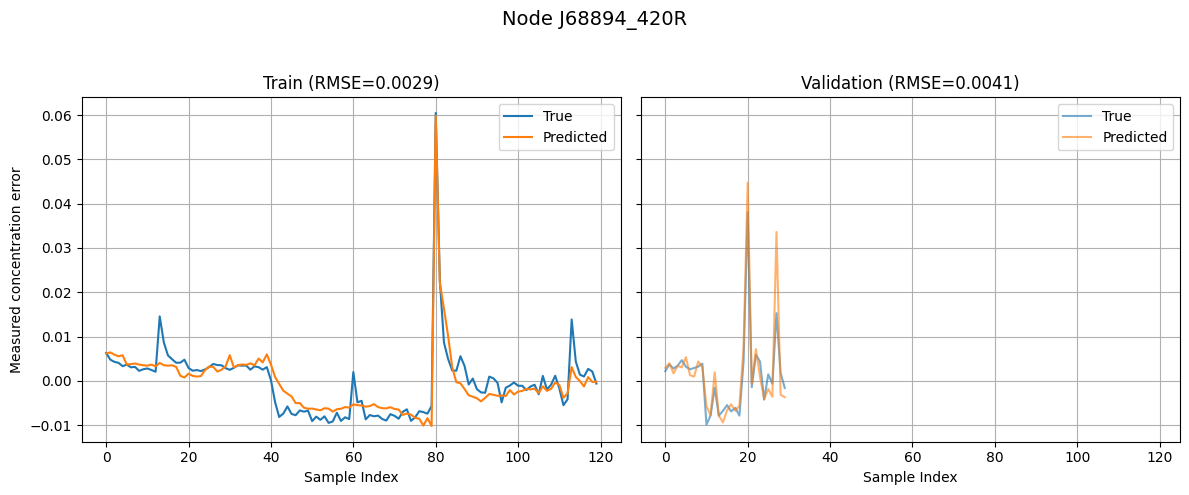

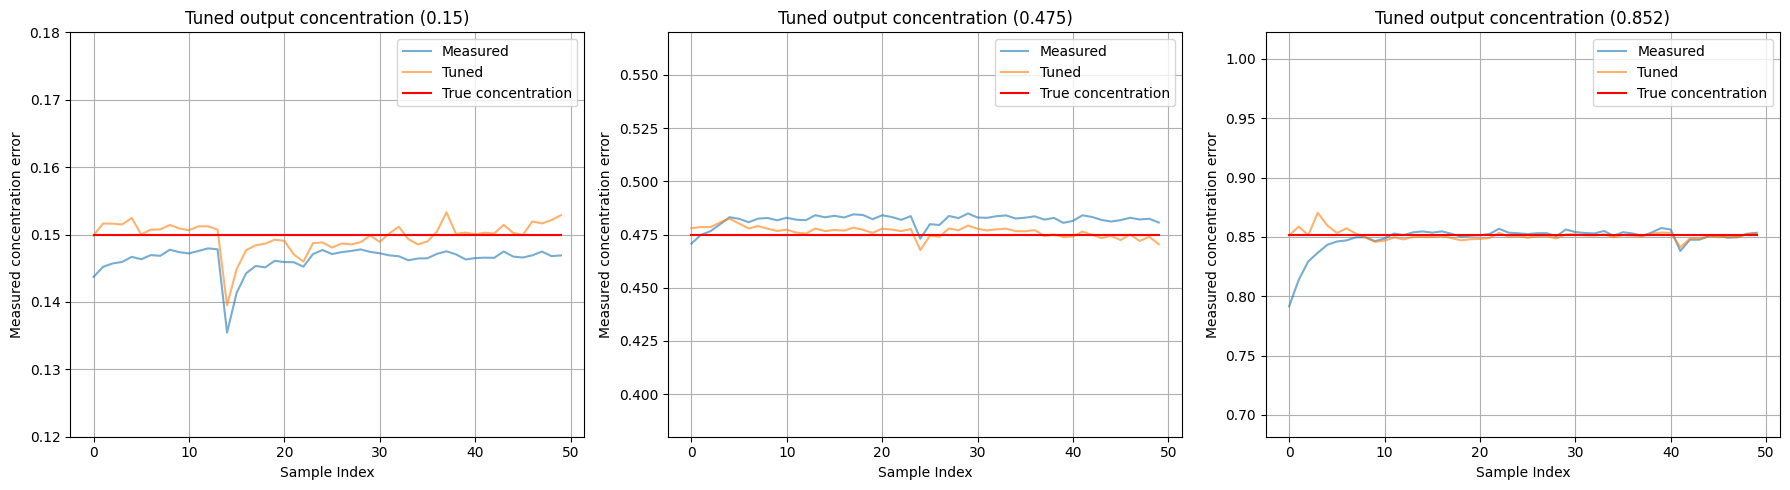

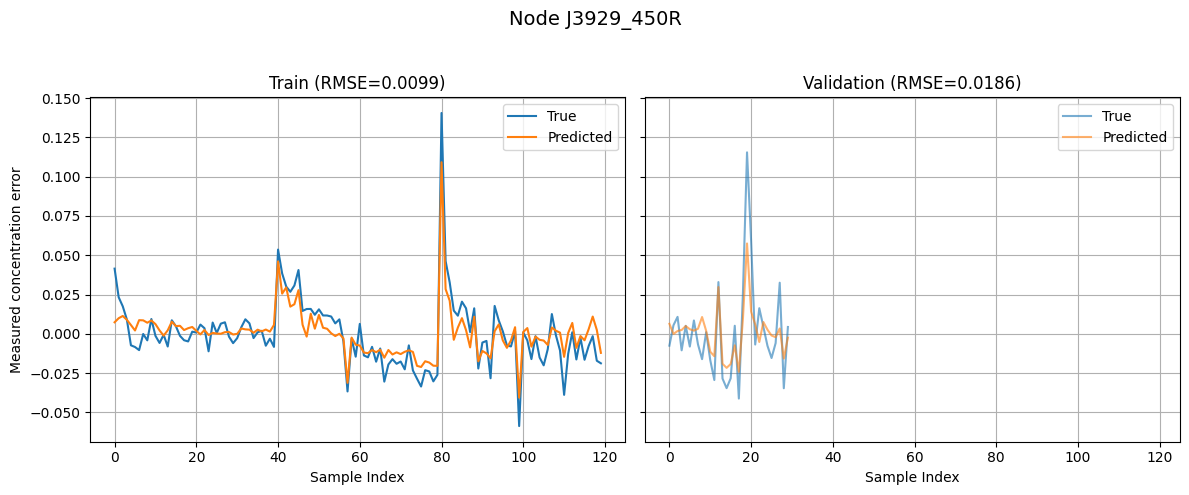

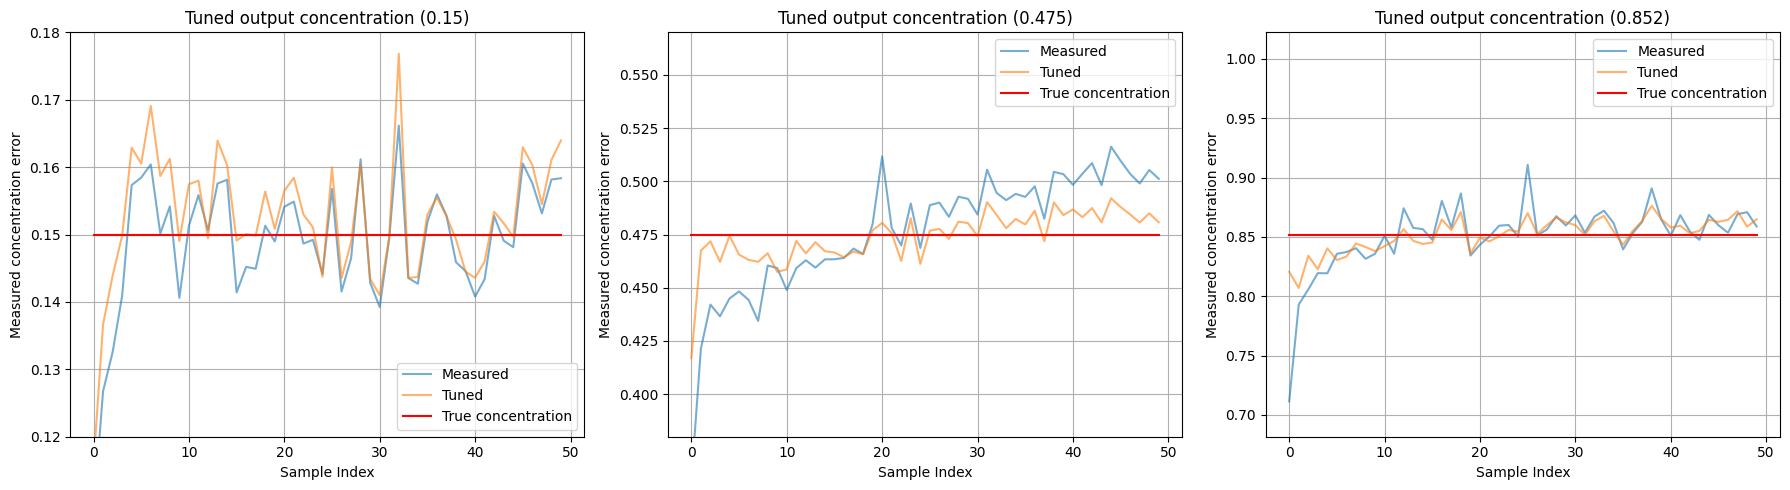

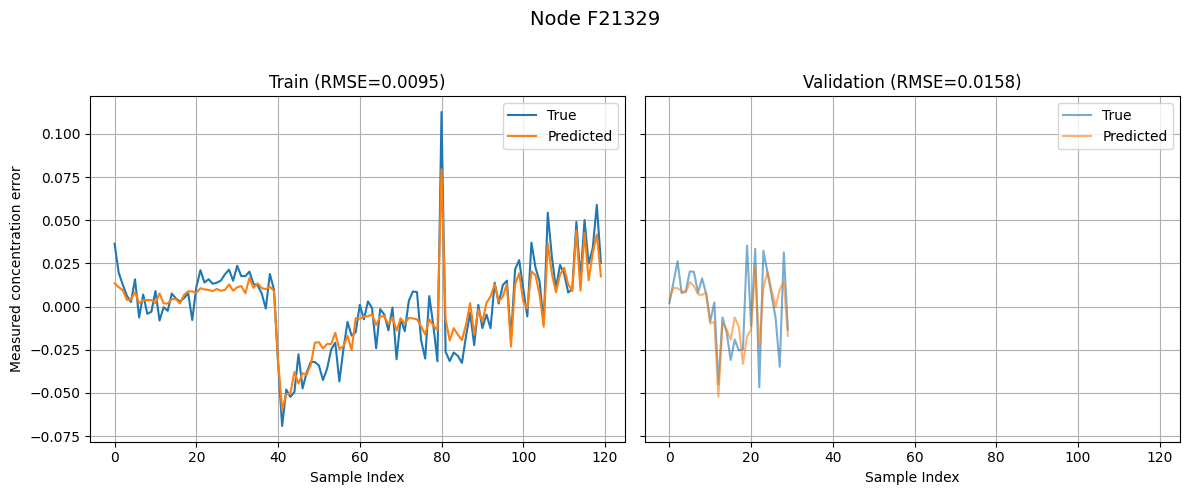

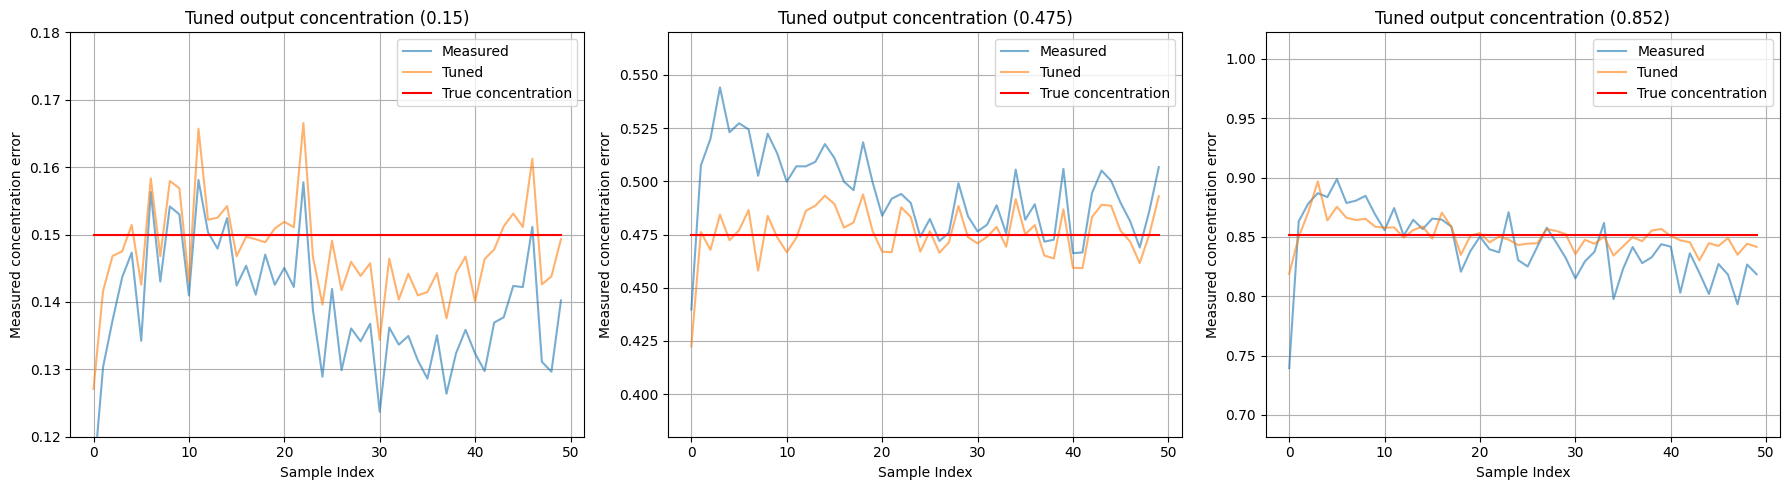

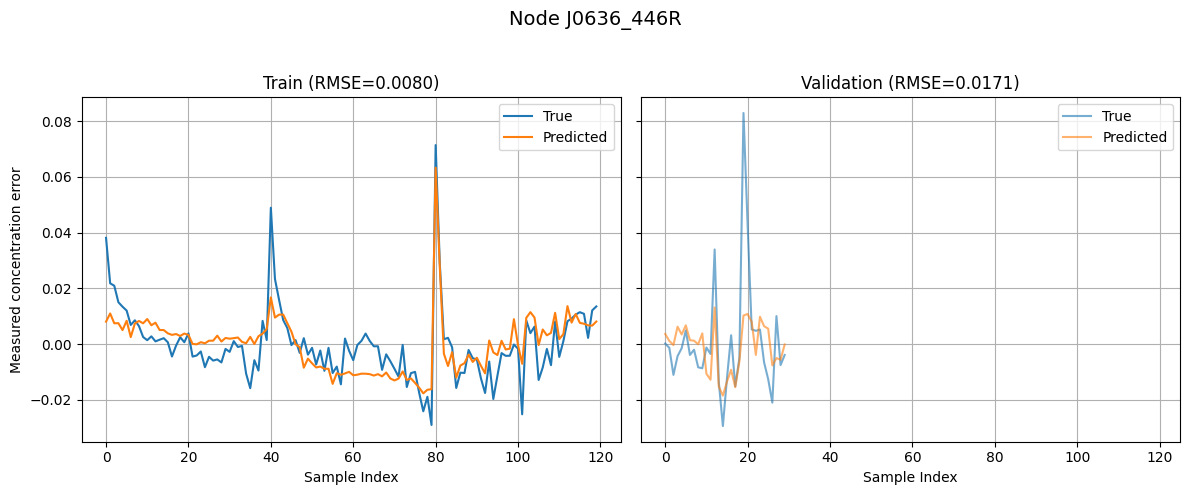

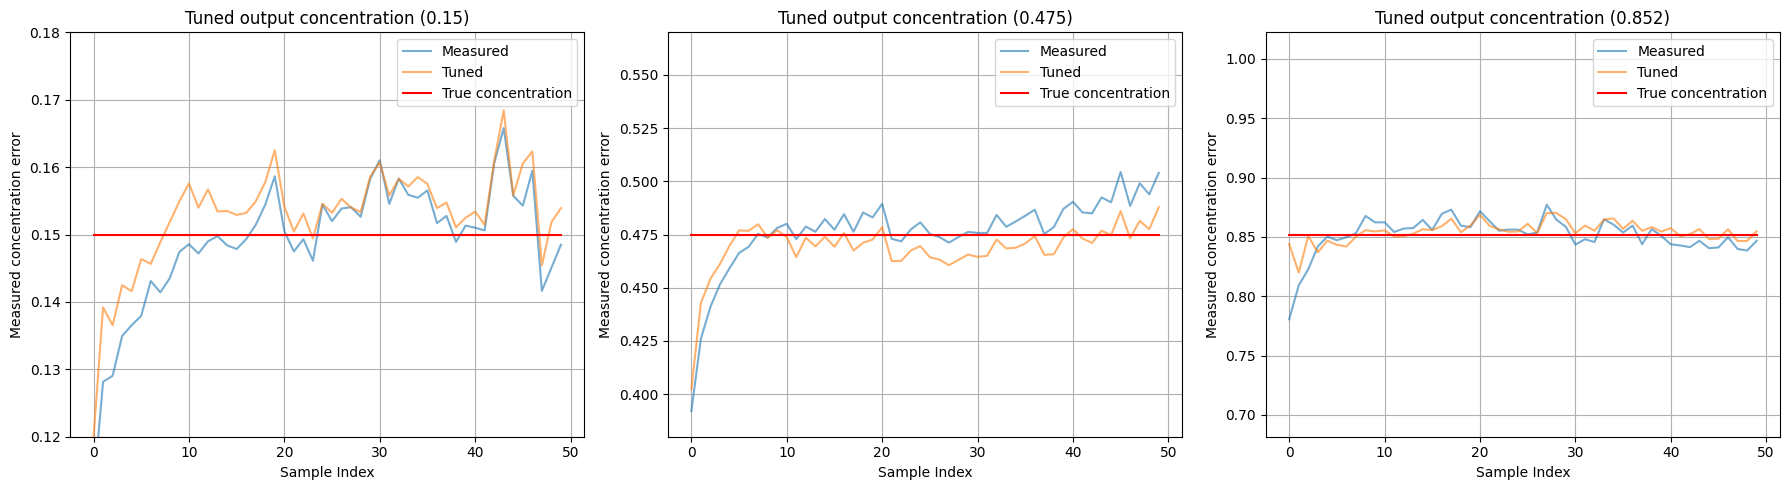

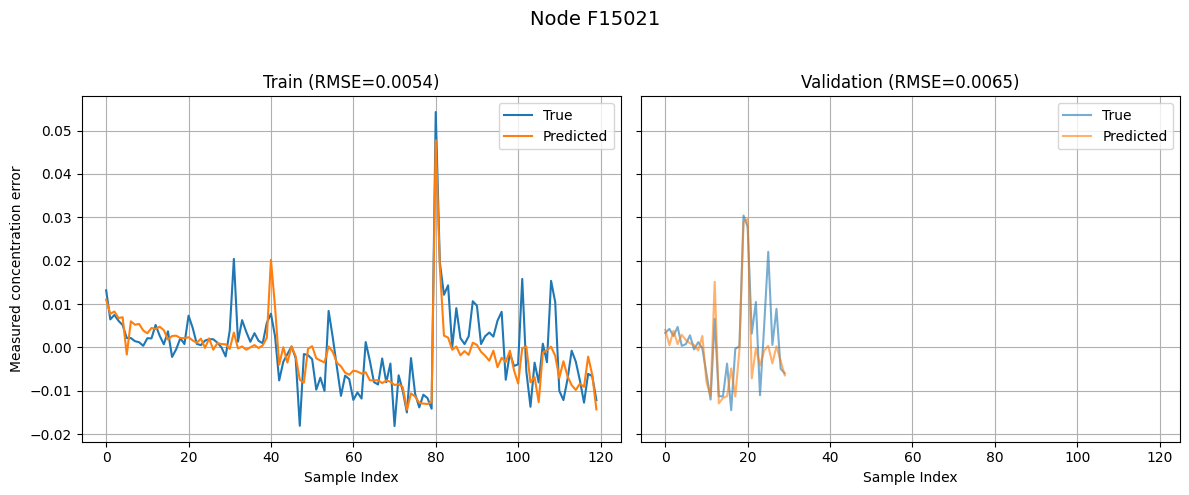

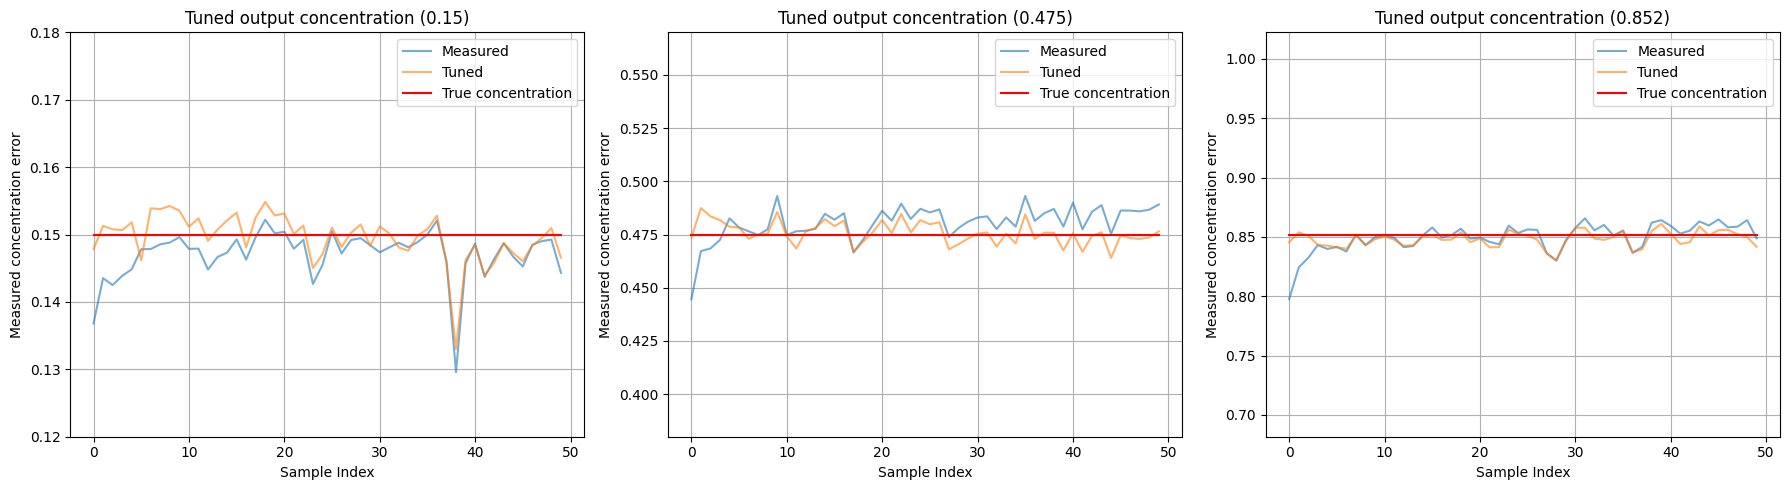

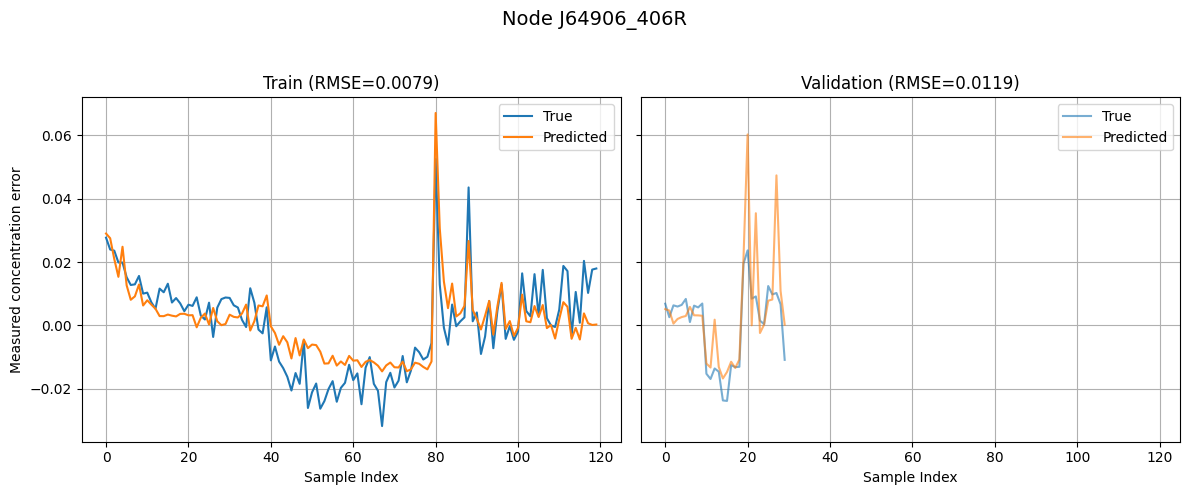

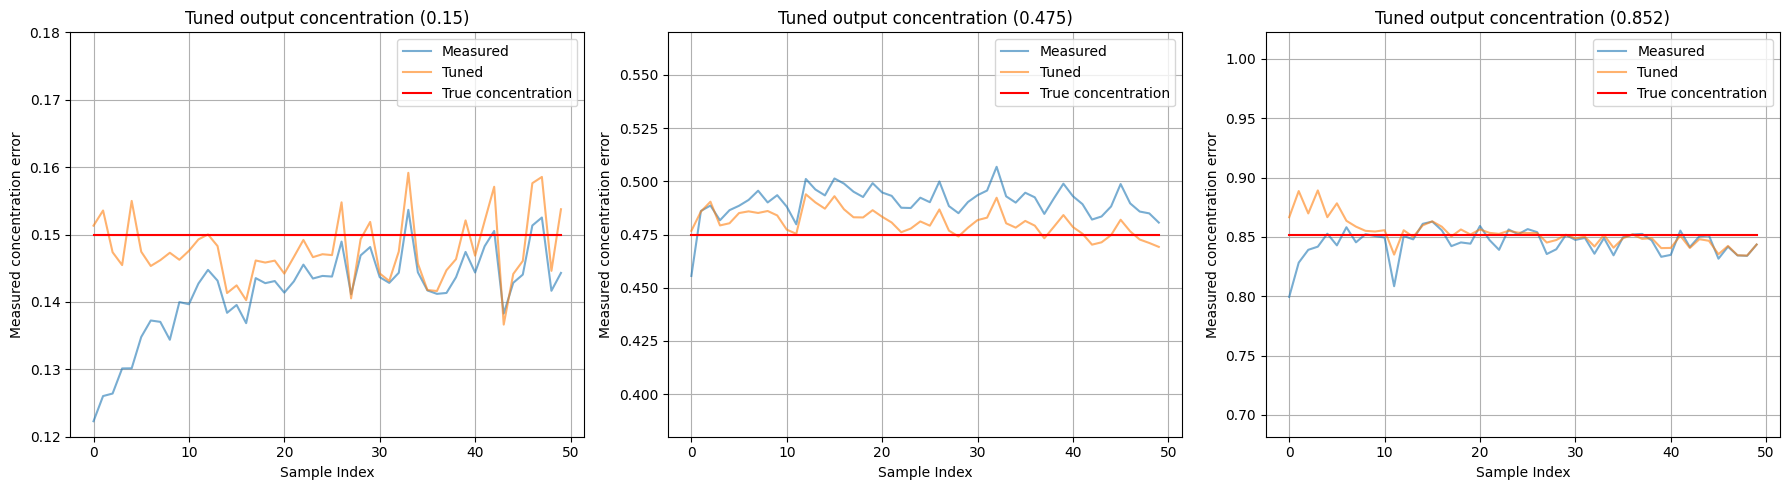

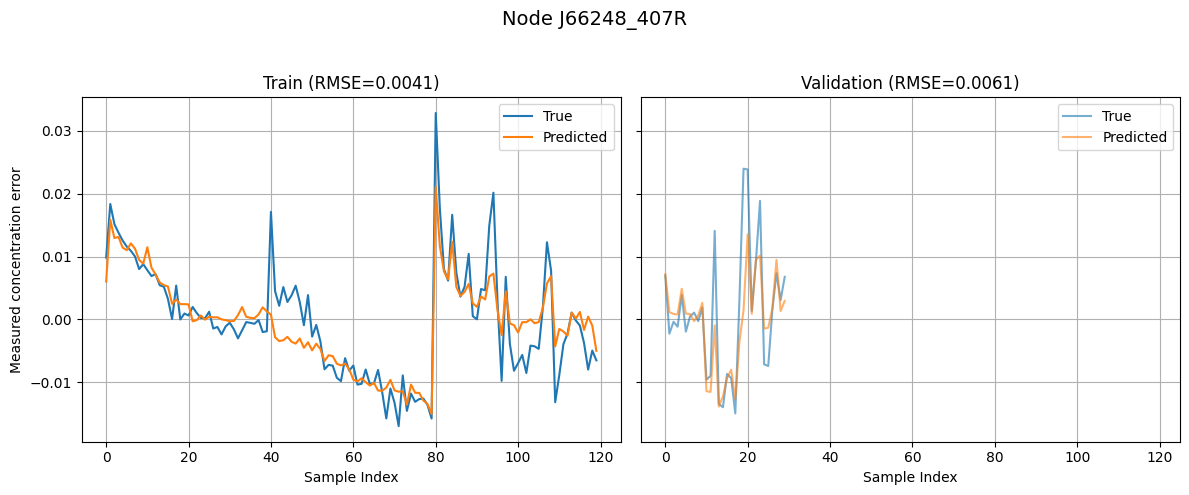

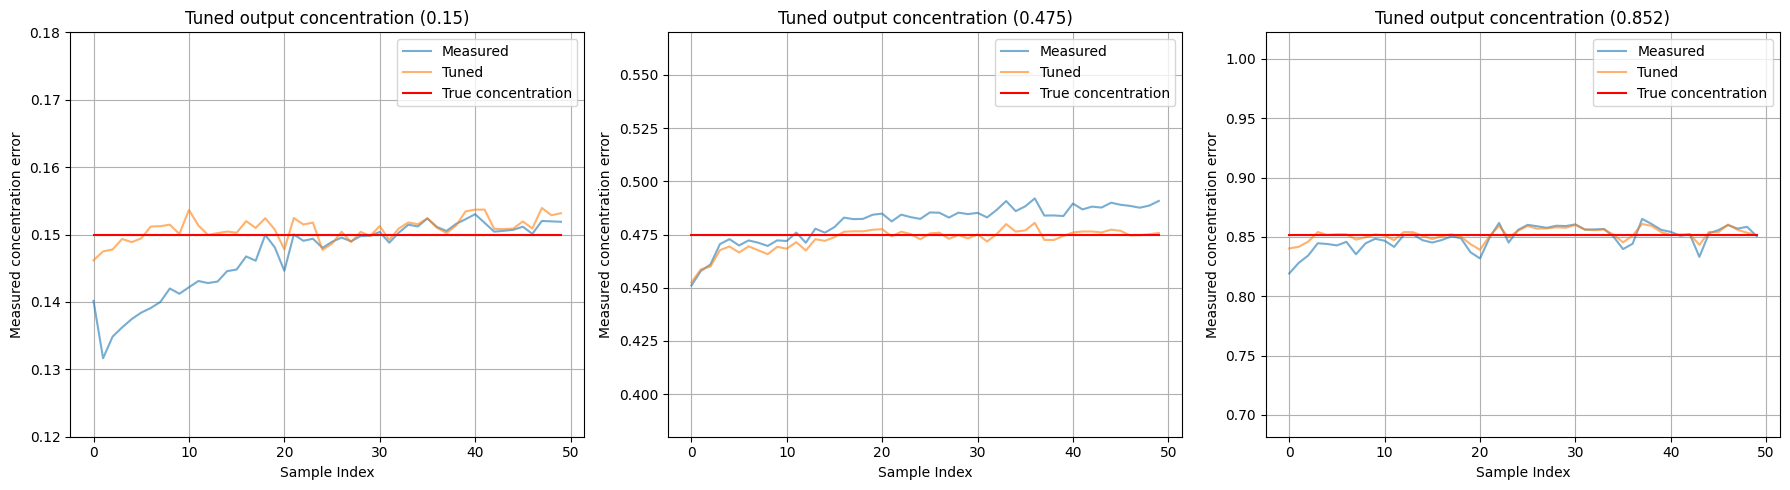

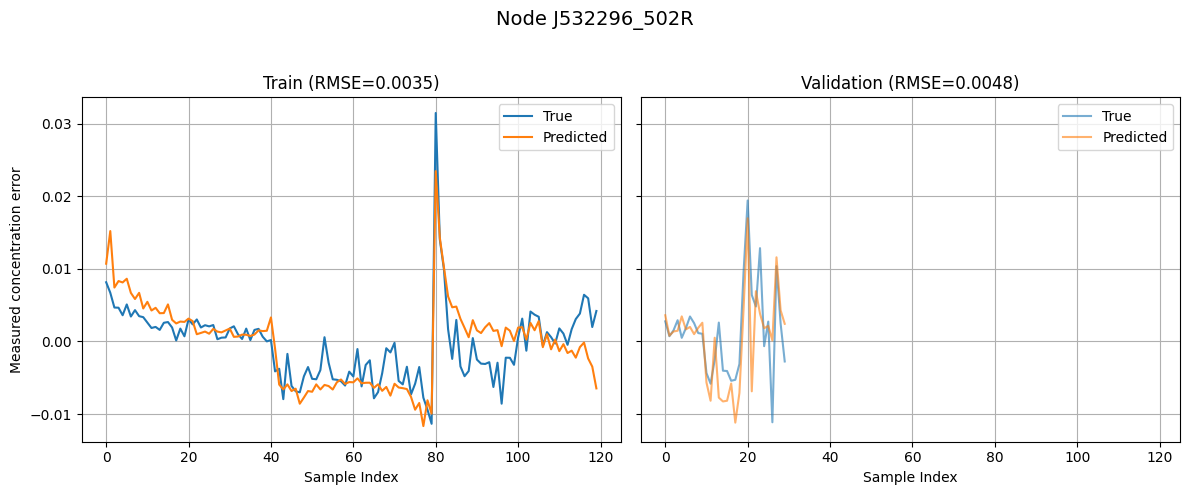

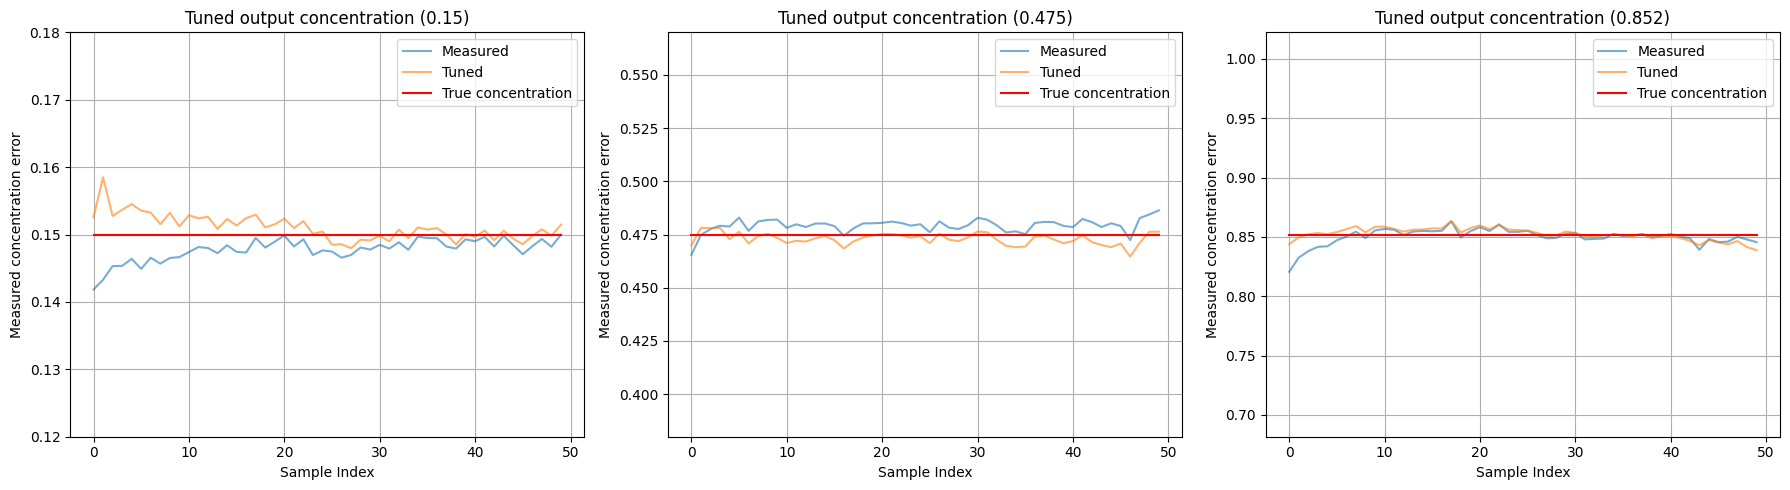

In [58]:
def load_node_models(graph, save_dir="fedmlp_models", device='cpu'):
    for node in graph.nodes:
        # Load checkpoint
        model_file = os.path.join(save_dir, f"model_node_{node}.pth")
        checkpoint = torch.load(model_file, map_location=device, weights_only=False)

        # Recreate MLP with correct input dimension
        input_dim = graph.nodes[node]['X_train'].shape[1]
        model = MLP(input_dim).to(device)

        # Load weights
        model.load_state_dict(checkpoint["model_state"])

        # Store in graph
        graph.nodes[node]['model'] = model
        graph.nodes[node]['scaler_mean'] = checkpoint["scaler_mean"]
        graph.nodes[node]['scaler_scale'] = checkpoint["scaler_scale"]

        # Set scaler inside the model (if your MLP uses it)
        model.set_scaler(
            checkpoint["scaler_mean"], checkpoint["scaler_scale"]
        )

    return graph

# Load all models before evaluation
G_sensors = load_node_models(G_sensors, save_dir="fedmlp_models", device='cpu')

# ---- Evaluation and plotting ----
for node in G_sensors.nodes:
    # --- Prepare data ---
    X_train = torch.tensor(G_sensors.nodes[node]['X_train'], dtype=torch.float32)
    y_train = torch.tensor(G_sensors.nodes[node]['y_train'], dtype=torch.float32)
    X_val   = torch.tensor(G_sensors.nodes[node]['X_val'], dtype=torch.float32)
    y_val   = torch.tensor(G_sensors.nodes[node]['y_val'], dtype=torch.float32)
    X_all   = torch.tensor(G_sensors.nodes[node]['X'], dtype=torch.float32)
    y_all   = torch.tensor(G_sensors.nodes[node]['y'], dtype=torch.float32)

    # Sensor-specific calibration data
    sensor_data = data[data['sensor'] == node]
    int0 = sensor_data['int0'].to_numpy()
    intp = sensor_data['intp'].to_numpy()
    k    = sensor_data['k'].to_numpy()
    b    = sensor_data['b'].to_numpy()
    conc_measured = ((int0 + intp) - b) / k

    # --- Predict ---
    model = G_sensors.nodes[node]['model']
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train).squeeze().numpy()
        y_val_pred   = model(X_val).squeeze().numpy()
        y_all_pred   = model(X_all).squeeze().numpy()

    y_train_true = y_train.numpy()
    y_val_true   = y_val.numpy()

    # --- Compute RMSE ---
    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    val_rmse   = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

    # --- Train/Validation fit plots ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    axes[0].plot(y_train_true, label='True')
    axes[0].plot(y_train_pred, label='Predicted')
    axes[0].set_title(f'Train (RMSE={train_rmse:.4f})')
    axes[0].set_xlabel('Sample Index')
    axes[0].set_ylabel('Measured concentration error')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(y_val_true, alpha=0.6, label='True')
    axes[1].plot(y_val_pred, alpha=0.6, label='Predicted')
    axes[1].set_title(f'Validation (RMSE={val_rmse:.4f})')
    axes[1].set_xlabel('Sample Index')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(f'Node {node}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(fname=f'plots/{node}_train_val_fit.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- Tuned concentration plots ---
    conc_levels = [0.15, 0.475, 0.852]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, conc_true in enumerate(conc_levels):
        start = idx * 50
        end   = start + 50
        axes[idx].plot(conc_measured[start:end], alpha=0.6, label='Measured')
        axes[idx].plot(conc_measured[start:end] + y_all_pred[start:end],
                       alpha=0.6, label='Tuned')
        axes[idx].plot(np.ones(50) * conc_true, color='red', linewidth=1.5,
                       label='True concentration')

        # Limit y-axis to ±20% of true concentration
        min_val = conc_true * 0.8
        max_val = conc_true * 1.2
        axes[idx].set_ylim(min_val, max_val)

        axes[idx].set_title(f'Tuned output concentration ({conc_true})')
        axes[idx].set_xlabel('Sample Index')
        axes[idx].set_ylabel('Measured concentration error')
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()